# Laboratory #5 : Object Detection with YOLO

At the end of this laboratory, you would get familiarized with

*   Object Detection on Medical Imaging
*   YOLOV5 for Object Detection using Keras and TensorFlow

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**

---

# **Authors**: Lloyd Linton Jones, Ihona Maria Correa de Cabo

In [ ]:
#Mount drive
#from google.colab import drive
#drive.mount('/content/drive')

# Detection with BCCD dataset

**About the dataset:** BCCD is a small-scale dataset for blood cells detection. It consists of a collection of high-resolution microscope images of blood cell samples (640x480). These images typically showcase a variety of blood cell types under different staining conditions and magnifications.Blodd cells classes are one of three types: Red Blood Cell, White Blood Cell or Platelet. The annotations consists of bounding boxes coordinates for each cell and their classes. There are 364 images with a total of 4888 blood cells annotated

In [ ]:
# Libraries
import os, sys, random, shutil
import xml.etree.ElementTree as ET
from glob import glob
import pandas as pd
from shutil import copyfile
import pandas as pd
from sklearn import preprocessing, model_selection
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches
import numpy as np

Change the directory to /content/ and clone the github repo: https://github.com/Shenggan/BCCD_Dataset.git

In [ ]:
#solution
%cd /content/
!git clone 'https://github.com/Shenggan/BCCD_Dataset.git'


/content
Cloning into 'BCCD_Dataset'...
remote: Enumerating objects: 800, done.
remote: Total 800 (delta 0), reused 0 (delta 0), pack-reused 800 (from 1)
Receiving objects: 100% (800/800), 7.39 MiB | 35.51 MiB/s, done.
Resolving deltas: 100% (378/378), done.


The annotations to this dataset come on an .xml format. Run the following code that prepares the annotations and train/validation sets and explain what the code is doing on detail.

In [ ]:
# Obtaining parsed XML into a dataframe for further pre-processing
annotations = sorted(glob('/content/BCCD_Dataset/BCCD/Annotations/*.xml'))

df = []
cnt = 0
for file in annotations:
  prev_filename = file.split('/')[-1].split('.')[0] + '.jpg'
  filename = str(cnt) + '.jpg'
  row = []
  parsedXML = ET.parse(file)
  for node in parsedXML.getroot().iter('object'):
    blood_cells = node.find('name').text
    xmin = int(node.find('bndbox/xmin').text)
    xmax = int(node.find('bndbox/xmax').text)
    ymin = int(node.find('bndbox/ymin').text)
    ymax = int(node.find('bndbox/ymax').text)

    row = [prev_filename, filename, blood_cells, xmin, xmax, ymin, ymax]
    df.append(row)
  cnt += 1

data = pd.DataFrame(df, columns=['prev_filename', 'filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax'])

data[['prev_filename','filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax']].to_csv('/content/blood_cell_detection.csv', index=False)
print(data.shape)
data.head()

(4888, 7)


,prev_filename,filename,cell_type,xmin,xmax,ymin,ymax
0,BloodImage_00000.jpg,0.jpg,WBC,260,491,177,376
1,BloodImage_00000.jpg,0.jpg,RBC,78,184,336,435
2,BloodImage_00000.jpg,0.jpg,RBC,63,169,237,336
3,BloodImage_00000.jpg,0.jpg,RBC,214,320,362,461
4,BloodImage_00000.jpg,0.jpg,RBC,414,506,352,445


In [ ]:
# Data structure required
img_width = 640
img_height = 480

def width(df):
  return int(df.xmax - df.xmin)
def height(df):
  return int(df.ymax - df.ymin)
def x_center(df):
  return int(df.xmin + (df.width/2))
def y_center(df):
  return int(df.ymin + (df.height/2))
def w_norm(df):
  return df/img_width
def h_norm(df):
  return df/img_height

df = pd.read_csv('/content/blood_cell_detection.csv')

le = preprocessing.LabelEncoder()
le.fit(df['cell_type'])
print(le.classes_)
labels = le.transform(df['cell_type'])
df['labels'] = labels

df['width'] = df.apply(width, axis=1)
df['height'] = df.apply(height, axis=1)

df['x_center'] = df.apply(x_center, axis=1)
df['y_center'] = df.apply(y_center, axis=1)

df['x_center_norm'] = df['x_center'].apply(w_norm)
df['width_norm'] = df['width'].apply(w_norm)

df['y_center_norm'] = df['y_center'].apply(h_norm)
df['height_norm'] = df['height'].apply(h_norm)

print(df.shape)

['Platelets' 'RBC' 'WBC']
(4888, 16)


In [ ]:
# Train test split
df_train, df_valid = model_selection.train_test_split(df, test_size=0.1, random_state=13, shuffle=True)
print(df_train.shape, df_valid.shape)

os.mkdir('/content/bcc/')
os.mkdir('/content/bcc/images/')
os.mkdir('/content/bcc/images/train/')
os.mkdir('/content/bcc/images/valid/')

os.mkdir('/content/bcc/labels/')
os.mkdir('/content/bcc/labels/train/')
os.mkdir('/content/bcc/labels/valid/')

def segregate_data(df, img_path, label_path, train_img_path, train_label_path):
  filenames = []
  for filename in df.filename:
    filenames.append(filename)
  filenames = set(filenames)

  for filename in filenames:
    yolo_list = []

    for _,row in df[df.filename == filename].iterrows():
      yolo_list.append([row.labels, row.x_center_norm, row.y_center_norm, row.width_norm, row.height_norm])

    yolo_list = np.array(yolo_list)
    txt_filename = os.path.join(train_label_path,str(row.prev_filename.split('.')[0])+".txt")
    # Save the .img & .txt files to the corresponding train and validation folders
    np.savetxt(txt_filename, yolo_list, fmt=["%d", "%f", "%f", "%f", "%f"])
    shutil.copyfile(os.path.join(img_path,row.prev_filename), os.path.join(train_img_path,row.prev_filename))

## Apply function ##
src_img_path = "/content/BCCD_Dataset/BCCD/JPEGImages/"
src_label_path = "/content/BCCD_Dataset/BCCD/Annotations/"

train_img_path = "/content/bcc/images/train"
train_label_path = "/content/bcc/labels/train"

valid_img_path = "/content/bcc/images/valid"
valid_label_path = "/content/bcc/labels/valid"

segregate_data(df_train, src_img_path, src_label_path, train_img_path, train_label_path)
segregate_data(df_valid, src_img_path, src_label_path, valid_img_path, valid_label_path)

print("No. of Training images", len(os.listdir('/content/bcc/images/train')))
print("No. of Training labels", len(os.listdir('/content/bcc/labels/train')))

print("No. of valid images", len(os.listdir('/content/bcc/images/valid')))
print("No. of valid labels", len(os.listdir('/content/bcc/labels/valid')))

(4399, 16) (489, 16)
No. of Training images 364
No. of Training labels 364
No. of valid images 270
No. of valid labels 270


Explain the code above:

**Solution**

The above code prepares a dataset of blood cell images for object detection using the YOLO algorithm.  It begins by mounting Google Drive to access and save files and then loads essential libraries for data processing and visualization. With the git clone command, it downloads the BCCD dataset, which contains microscope images of 3 types of blood cells (Red, White and platelets) with bounding box annotations in XML files. The XML files are then parsed in order to extract details about the cell's bounding box coordinates and type, which are then stored in a pandas dataframe and saved as a CSV file for better manipulation.

There are several functions that calculate each bounding box width, height and central coordiantes. Afterwards, these are normalized (between 0 and 1) based on the image dimensions in order to meet with the YOLO requirements.
The blood cell types are converted into numeric labels by using the label encoder for YOLO’s object classification. Afterwards, the dataset is split into training (90%) and validation (10%) sets.  

Specific directories are created for images and labels in YOLO’s format, separating training and validation data.

The code also defines a function (segregate_data) to convert the bounding box annotations into YOLO format, where each object is represented by [class, x_center_norm, y_center_norm, width_norm, height_norm]. This function saves each image’s annotations into a text file with the same name as the image, placing both images and annotations in their designated folders.

**Plot first 5 images with their bounding boxes and display the label of each box (use different colors for different classes). Leverage the dataframe with information regarding class and position of the boxes for each image. matplotlib has a useful function call patches to create the boxes. Your final outcome for each imge should look similar to this:**  

![annotated](https://cdn-images-1.medium.com/max/433/1*Nl9tCJfVJfBjLK-7IO_D8A.png)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os
from PIL import Image

# Load the dataset that contains the bounding box data
df = pd.read_csv('blood_cell_detection.csv')

# Define a dictionary to map the cell types to colors to distinguish them better
cell_type_colors = {
    'RBC': 'red', # Red blood cell bounding box will be red
    'WBC': 'blue', # White blood cell bounding box will be blue
    'Platelet': 'green' # The platelet bounding box will be green
}

# Directory where images are stored
image_dir = 'BCCD_Dataset/BCCD/JPEGImages/'

def plot_image_with_bounding_boxes(image_name, df):
    # Filter data for the specified image
    image_data = df[df['filename'] == image_name]
    original_image_name = image_data['prev_filename'].iloc[0]  # Retrieve the original filename

    # Load the image
    image_path = os.path.join(image_dir, original_image_name)
    image = Image.open(image_path)
    image = image.resize((img_width, img_height))

    # Plot the image
    fig = plt.figure(frameon=False, figsize=(8, 5))
    plt.imshow(image)
    ax = plt.gca()

    # Plot each bounding box
    for _, row in image_data.iterrows():
        # Extract bounding box coordinates and cell type
        xmin, xmax, ymin, ymax = row['xmin'], row['xmax'], row['ymin'], row['ymax']
        cell_type = row['cell_type']
        color = cell_type_colors.get(cell_type, 'yellow')  # Set default color to yellow if cell type is unknown

        # Draw the bpunding box rectangle
        rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

        # Add the label
        ax.text(xmin, ymin - 5, cell_type, color=color, fontsize=10, weight='bold')

    plt.axis('off')

    return fig, ax


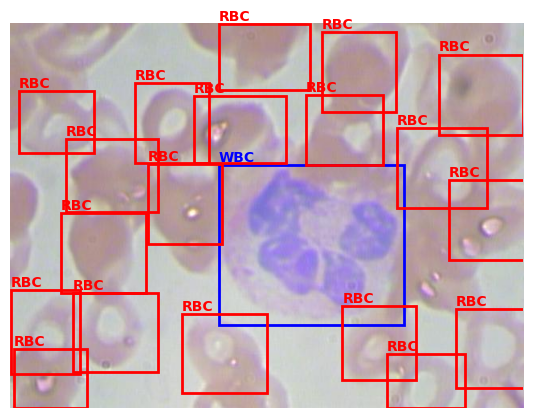

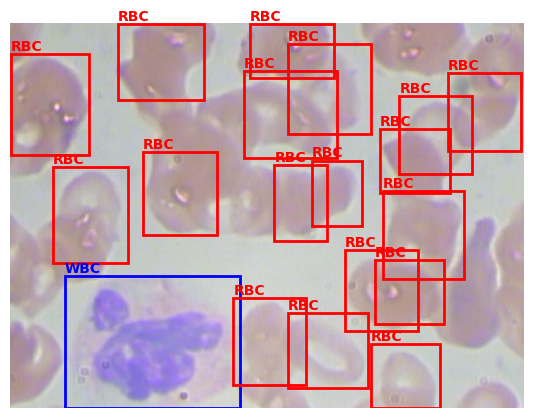

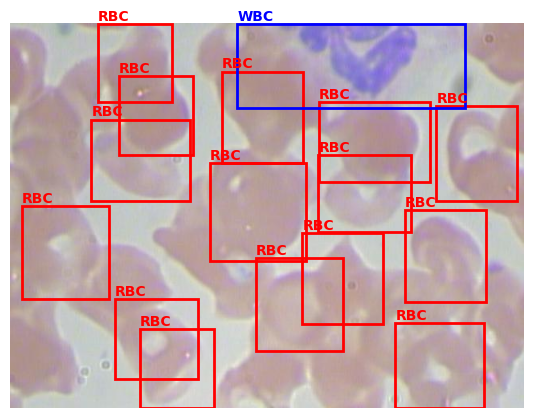

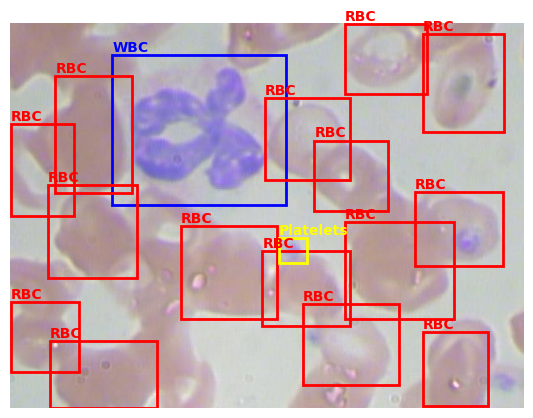

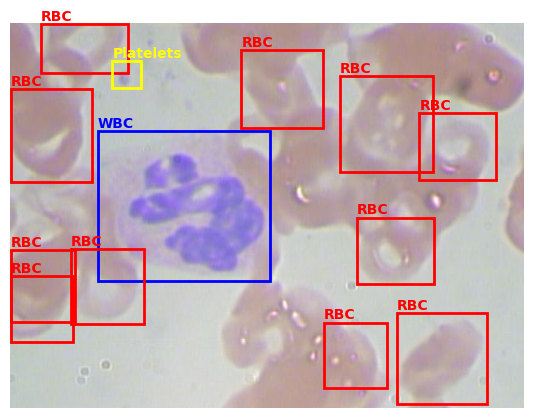

In [ ]:
# Get the first 5 images and plot them with their bounding boxes
unique_images = df['filename'].unique()[:5] # We take 5 unique images
for image_name in unique_images:
  fig, ax = plot_image_with_bounding_boxes(image_name, df)
  plt.show()

#### Yolo V5 training

For this dataset, we are going to use YoloV5


First we are going to clone the github repository and install its dependencies. Repo: https://github.com/ultralytics/yolov5.git and requirements are going to be in /content/yolov5/requirements.txt

In [ ]:
!git clone  'https://github.com/ultralytics/yolov5.git'
!pip install -qr '/content/yolov5/requirements.txt'  # install dependencies

Cloning into 'yolov5'...
remote: Enumerating objects: 17022, done.
remote: Total 17022 (delta 0), reused 0 (delta 0), pack-reused 17022 (from 1)
Receiving objects: 100% (17022/17022), 15.62 MiB | 28.92 MiB/s, done.
Resolving deltas: 100% (11694/11694), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.2/881.2 kB 22.1 MB/s eta 0:00:00


In [ ]:
%cd yolov5
%pip install -qr requirements.txt comet_ml  # install

import torch
import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-378-g2f74455a Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.5/112.6 GB disk)


The following code creates a yaml file with some specifications for the training of this data such as train and validation path, classes, etc.

In [ ]:
# Create yaml file
%cd /content/
!echo "train: /content/bcc/images/train" >> bcc.yaml
!echo "val: /content/bcc/images/valid" >> bcc.yaml
!echo "" >> bcc.yaml
!echo "nc: 3" >> bcc.yaml
!echo "" >> bcc.yaml
!echo "names: ['Platelets', 'RBC', 'WBC']" >> bcc.yaml
!cat bcc.yaml

/content
train: /content/bcc/images/train
val: /content/bcc/images/valid

nc: 3

names: ['Platelets', 'RBC', 'WBC']


In [ ]:
# Move yaml into the yolov5 folder
shutil.copyfile('/content/bcc.yaml', '/content/yolov5/bcc.yaml')

'/content/yolov5/bcc.yaml'

In [ ]:
# Edit yaml file to specify categories of model yolov5s
!awk '/nc: 80/{$2="3"}1' /content/yolov5/models/yolov5s.yaml > tmp.yaml && mv tmp.yaml /content/yolov5/models/yolov5s.yaml


Train for 25 epochs with a batch size of 16, make sure to use **tensorboard** to visualize the training process. Here is a starter code for the training call:

```python
!python /content/yolov5/train.py --img value --batch value --epochs value \
    --data bcc.yaml --cfg /content/yolov5/models/yolov5s.yaml --name BCCM
```

Change the "value" to the appropriate one based on the description of the task.

In [ ]:
!python /content/yolov5/train.py --img 640 --batch 16 --epochs 25 \
    --data bcc.yaml --cfg /content/yolov5/models/yolov5s.yaml --name BCCM


2024-11-07 09:01:20.558750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 09:01:20.590070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 09:01:20.599823: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5/yolov5s.pt, cfg=/content/yolov5/models/yolov5s.yaml, data=bcc.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=25, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=Fal

**Comment on your results: What is the current accuracy? Is this a good performance level?**

**Solution**

The results are broken down by class (all classes, Platelets, RBC, and WBC).

- We can observe that the precison values are low, especially for the RBC, which suggests that the model is making many false positive detections. Precision measures the accuracy of the positive predictions, so a small precision may lead to inaccurate identification of cell types.

- Higher recall means fewer false negatives, and in this case the recall values were high, particulary for WBC.This means that the model is detecting most of the objects present in the images. Nevertheless, a high recall combined with low precision suggests the model struggles with correctly identifying the objects it detects.

- On the other hand, mAP50 is the mean average precision at a 0.5 Intersection over Union (IoU) threshold. It measures the accuracy of both bounding box localization and class prediction, where a higher mAP indicates better accuracy.The mAP50 scores are low for all classes, which means that the model has limited accuracy in both localizing objects and classifying them correctly.

- Finally, mAP50-95 is a stricter version of mAP, and is averaged over multiple IoU thresholds (from 0.5 to 0.95 in 0.05 increments). This metric reflects both precision and recall across various levels of overlap between predicted and actual bounding boxes. Here the scores are also very low, suggesting that the model is struggling with precise localization and classification across the different levels of overlap.

In conclusion, this is not a good performance level, especially in medical imaging where the accuracy is important. High recall alone is not enough to ensure the model is working properly.

**Inference:**

 Predict /content/bcc/images/valid/BloodImage_00000.jpg images and **plot** its results (this is created and saved at the yolov5/runs/detect/exp directory).

 Hint: To predict, there is a /content/yolov5/detect.py scripts. You can specify the image to predict, the weights yolov5/runs/train/weights/best.pt and save the results as txt.


In [ ]:
!python /content/yolov5/detect.py \
--weights /content/yolov5/runs/train/BCCM/weights/best.pt \
--img 640 --conf 0.25 --source /content/bcc/images/valid/BloodImage_00000.jpg

detect: weights=['/content/yolov5/runs/train/BCCM/weights/best.pt'], source=/content/bcc/images/valid/BloodImage_00000.jpg, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-378-g2f74455a Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/bcc/images/valid/BloodImage_00000.jpg: 480x640 22 RBCs, 1 WBC, 27.2ms
Speed: 0.5ms pre-process, 27.2ms inference, 726.4ms NMS per image at shape (1, 3, 640, 640)
Results saved to yolov5/runs/de

Compare the provided annotations to the resulted ones by visually overlaying the original boxes over the predicted image you just plotted.


*   Load and display the image with the predictions
*   Overlay the actual annotations as you already did



In [ ]:
from PIL import Image

# Generate original image with bounding box
image_required = 'BloodImage_00000.jpg'
filename_original = str(df[df['prev_filename'] == image_required]['filename'].iloc[0])
fig_original, ax_original = plot_image_with_bounding_boxes(filename_original, df);
fig_original.savefig(f'original_{image_required.split(".")[0]}.png');
plt.close(fig_original)
# Generate compatable detected image
image_detect = Image.open('/content/yolov5/runs/detect/exp/BloodImage_00000.jpg')
image_detect = image_detect.resize((img_width, img_height))
image_detect = image_detect.convert("RGBA")
fig_detect = plt.figure(frameon=False, figsize=(8, 5))
plt.imshow(image_detect)
ax_detect = plt.gca()
ax_detect.axis('off')
fig_detect.savefig(f'detect_{image_required.split(".")[0]}.png');
plt.close(fig_detect)

In [ ]:
image_original = Image.open(f'original_{image_required.split(".")[0]}.png')
image_original = image_original.resize((img_width, img_height))
image_original = image_original.convert("RGBA")

image_detect = Image.open(f'detect_{image_required.split(".")[0]}.png')
image_detect = image_detect.resize(image_original.size)
image_detect = image_detect.convert("RGBA")

In [ ]:
image_blended = Image.blend(image_original, image_detect, alpha=0.5)
image_blended.save(f'blended_{image_required.split(".")[0]}.png')

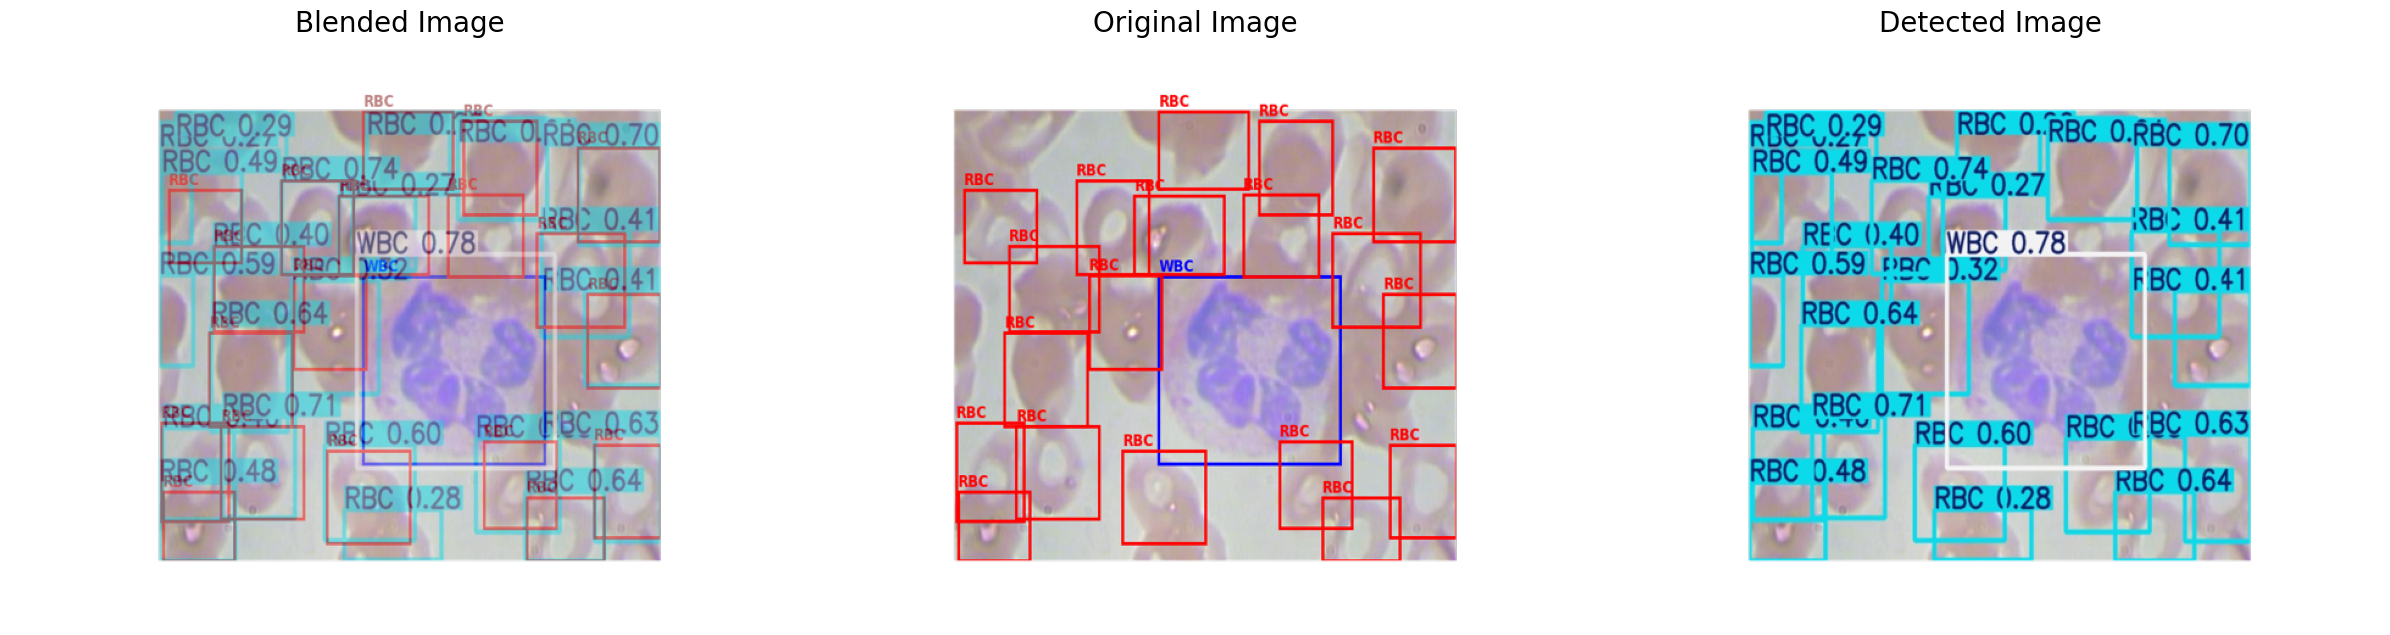

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(24, 15))
ax[0].imshow(image_blended)
ax[0].set_title('Blended Image', fontsize=20)
ax[0].axis('off')
ax[1].imshow(image_original)
ax[1].set_title('Original Image', fontsize=20)
ax[1].axis('off')
ax[2].imshow(image_detect)
ax[2].set_title('Detected Image', fontsize=20)
ax[2].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show(fig)

# Understanding Object Detection

*   **What is the latest YOLO version available in literature? Provide a brief summary of this version.**

**Solution**

The latest version of the YOLO algorith is version 11. YOLO11, the latest release from Ultralytics, introduces multiple significant improvements in both functionality and efficiency compared to previous versions. The architecture has been optimized to boost accuracy and reduce computational demands, making it especially useful for edge devices and real-time applications. YOLO11 achieves a higher mean Average Precision (mAP) across all model sizes, up to 2.2% on COCO object detection tasks compared to YOLOv8, and uses up to 22% fewer parameters, enhancing its inference speed by approximately 2%​

This version also broadens its support for diverse computer vision tasks, including object detection, instance segmentation, pose estimation, and oriented object detection, all while maintaining efficiency. Additionally, YOLO11 integrates seamlessly with cloud and edge platforms, and Ultralytics HUB, a platform for training and deploying models, facilitates its usage across various AI projects, from agriculture to healthcare applications.

[https://docs.ultralytics.com/models/yolo11/]

*   **What are the other object detection frameworks available in the literature?**

**Solution**

Faster R-CNN (Region-based Convolutional Neural Network)
EfficientDet
RetinaNet
Mask R-CNN
CenterNet
DETR
Cascade R-CNN
SSD (Single Shot multibox detector)
FCOS (Fully Convolutional One-Stage Object Detection)

*   **What are the drawbacks in object detection frameworks?**

**Solution**

**Trade-off Between Speed and Accuracy:** Many frameworks must balance speed and accuracy, but achieving high levels of both remains challenging. For example, YOLO and SSD offer high-speed processing but may sacrifice some accuracy, whereas two-stage detectors like Faster R-CNN focus on accuracy at the cost of slower inference speeds. This makes it hard to meet real-time application demands in high-precision settings​

**Computational Demands:** Complex models, especially transformer-based ones like DETR, require significant computational resources, making deployment on mobile devices or edge computing environments difficult. Such resource intensity limits their usability in environments with limited hardware​

**Object Occlusion and Small Object Detection:** Detecting partially occluded objects or very small objects in a scene remains problematic. While some models address this by refining anchor boxes or multi-scale detection, accurately identifying these objects in dense or cluttered scenes is still a limitation for most frameworks​

**Generalization Across Domains:** Object detection frameworks often perform well in the domains they are trained on but may struggle in unfamiliar environments. Changes in lighting, weather, or background can degrade performance significantly, necessitating additional fine-tuning or domain adaptation strategies to ensure reliability in diverse settings​

**Class Imbalance:** In datasets where certain classes dominate, frameworks may struggle to accurately detect less common objects. This imbalance often results in biased predictions, as models may prioritize frequent classes, potentially overlooking rare but important objects​



*   **Explain the performance metrics used over this notebook. What values reflect good performance?**

**Solution**

**Accuracy**: Measures the percentage of correct predictions overall. However, it’s less informative for object detection, especially if classes are imbalanced.

**Precision**: Focuses on the accuracy of positive predictions. High precision means that when the model predicts an object, it’s often correct. This is an important metric to minimize false positives.

**Recall**: Reflects the model's ability to find all relevant objects. High recall ensures that most instances of the objects are detected, which is critical when missing an object could cause harm or incur a cost.

**F1-score**: Balances precision and recall, providing an overall performance metric. A high F1-score indicates few false positives and false negatives.

**Mean Average Precision (mAP)**: A primary metric in object detection, mAP measures average precision across classes and thresholds. High mAP (close to 1.0) indicates strong detection performance and precise localization, crucial for tasks that need accuracy in identifying and bounding objects.

In general, values closer to 1.0 reflect better performance, but the desired level varies by application. Higher values are especially critical in safety-sensitive fields like medical analysis or diagnosis.




---

# **End of Object Detection with YOLO**
Deadline forsubmission in CampusVirtual is: **7 november 2024**